# 5 EV Charger

This notebook provides an example of just an EV charger running with a simple weekly schedule for the car being connected.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import importlib
from datetime import datetime,tzinfo,timezone,timedelta
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import electrichouse as eh
from electrichouse.controllers import  PlanController,do_nothing_step_function
from electrichouse.components.inputs import (
    TempAndPVInputParams,
    TempAndPVComponent,
    HouseInflexibleLoadInputParams,
    HouseInflexibleLoadComponent,
)
from electrichouse.components.grid import (
    SingleRateTariffInputParams,
    SingleRateTariffComponent,
    OctopusAgileTariffComponent,
    GridInputParams,
    GridComponent,
)

from electrichouse.components.ev import EVChargerComponent,EVChargerInputParams 

importlib.reload(eh)

<module 'electrichouse' from '/Users/benaylott/projects/electrichouse/electrichouse/__init__.py'>

## Setup controller/run model

In [4]:
%%time

def grid_control(tandpv_pv_generation_kW,house_load_usage_kW,ev_charging_rate_kW,**kwargs): 
    return {"grid_requested_kw": -(tandpv_pv_generation_kW + house_load_usage_kW+ev_charging_rate_kW)}

def evse_control(**kwargs):
    return {"ev_charger_enabled": True}

plan=OrderedDict({
    "tandpv":{
        "input_params":TempAndPVInputParams(
            weather_data_filepath=Path(f"{os.path.abspath('')}/../data/weather_data.csv"),
            weather_data_year= 2014,
            pv_power_kW= 3,
        ),
        "control_params_init":{},
        "class":TempAndPVComponent,
        "step_function":do_nothing_step_function,
    }, 
    "house_load":{
        "input_params":HouseInflexibleLoadInputParams(
            data_csv_filepath=Path(f"{os.path.abspath('')}/../data/loadm.csv"),
        ),
        "control_params_init":{},
        "class":HouseInflexibleLoadComponent,
        "step_function":do_nothing_step_function,
    },
    "ev":{
        "input_params":EVChargerInputParams(
            ev_charger_kW= 7.0,
            ev_battery_size_kWh= 42.0,
        ),
        "control_params_init":{},
        "class":EVChargerComponent,
        "step_function":evse_control,
    },
    "grid":{
        "input_params":GridInputParams(
            min_kw=-3.68,
            max_kw= 23,
        ),
        "control_params_init":{},
        "class":GridComponent,
        "step_function":grid_control,
    },
    "tariff":{
        "input_params":SingleRateTariffInputParams(
            grid_import_price_pounds_per_kWh= 0.3,
            grid_export_price_pounds_per_kWh= 0.05,
        ),
        "control_params_init":{},
        "class":SingleRateTariffComponent,
        "step_function":do_nothing_step_function,
    }, 
})

sc=PlanController(
    time_interval=timedelta(minutes=30),
    start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
    end_time=datetime(year=2022, month=1, day=1, tzinfo=timezone.utc),
    input_params={},
    control_params_init={},
    plan=plan
)

output=[]
for res in sc:
    output.append(res)

CPU times: user 2.23 s, sys: 33 ms, total: 2.27 s
Wall time: 2.28 s


## Analyse model results

In [5]:
outputd=pd.DataFrame.from_records(output,index='timestamp')


In [6]:
outputd[["tandpv_pv_generation_kW","house_load_usage_kW","grid_supplied_kW","ev_charging_rate_kW"]].values.sum(axis=1).sum(axis=0)

0.0

(convert index to DatetimeIndex to access convenience methods)

In [7]:
outputd.index=pd.DatetimeIndex(outputd.index)

Print a sample of data from the output

In [8]:
outputd.head()

tandpv_pv_generation_kW  tandpv_outdoor_temp_C  \
timestamp                                                                   
2021-01-01 00:00:00+00:00                      0.0                   4.60   
2021-01-01 00:30:00+00:00                      0.0                   4.79   
2021-01-01 01:00:00+00:00                      0.0                   4.98   
2021-01-01 01:30:00+00:00                      0.0                   5.17   
2021-01-01 02:00:00+00:00                      0.0                   5.36   

                           house_load_usage_kW  ev_battery_level_kWh  \
timestamp                                                              
2021-01-01 00:00:00+00:00               -0.242                  42.0   
2021-01-01 00:30:00+00:00               -0.300                  42.0   
2021-01-01 01:00:00+00:00               -1.318                  42.0   
2021-01-01 01:30:00+00:00               -0.776                  42.0   
2021-01-01 02:00:00+00:00               -0.894                  42.0   

                           ev_charging_session_kWh  ev_connected  \
timestamp                                                          
2021-01-01 00:00:00+00:00                      0.0          True   
2021-01-01 00:30:00+00:00                      0.0          True   
2021-01-01 01:00:00+00:00                      0.0          True   
2021-01-01 01:30:00+00:00                      0.0          True   
2021-01-01 02:00:00+00:00                      0.0          True   

                           ev_energy_used_kWh  ev_charging_rate_kW  \
timestamp                                                            
2021-01-01 00:00:00+00:00                 0.0                  0.0   
2021-01-01 00:30:00+00:00                 0.0                  0.0   
2021-01-01 01:00:00+00:00                 0.0                  0.0   
2021-01-01 01:30:00+00:00                 0.0                  0.0   
2021-01-01 02:00:00+00:00                 0.0                  0.0   

                           grid_supplied_kW  \
timestamp                                     
2021-01-01 00:00:00+00:00             0.242   
2021-01-01 00:30:00+00:00             0.300   
2021-01-01 01:00:00+00:00             1.318   
2021-01-01 01:30:00+00:00             0.776   
2021-01-01 02:00:00+00:00             0.894   

                           tariff_grid_import_price_pounds_per_kWh  \
timestamp                                                            
2021-01-01 00:00:00+00:00                                      0.3   
2021-01-01 00:30:00+00:00                                      0.3   
2021-01-01 01:00:00+00:00                                      0.3   
2021-01-01 01:30:00+00:00                                      0.3   
2021-01-01 02:00:00+00:00                                      0.3   

                           tariff_grid_export_price_pounds_per_kWh  
timestamp                                                           
2021-01-01 00:00:00+00:00                                     0.05  
2021-01-01 00:30:00+00:00                                     0.05  
2021-01-01 01:00:00+00:00                                     0.05  
2021-01-01 01:30:00+00:00                                     0.05  
2021-01-01 02:00:00+00:00                                     0.05

Get the EV battery level in kWh for a specific 2 day period. 

/var/folders/mp/9bhmbnwn27xbd_gqz129g9880000gn/T/ipykernel_71830/2633051479.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  outputd["ev_battery_level_kWh"][datetime(year=2021,month=3,day=3):datetime(year=2021,month=3,day=5)].plot()


<AxesSubplot: xlabel='timestamp'>

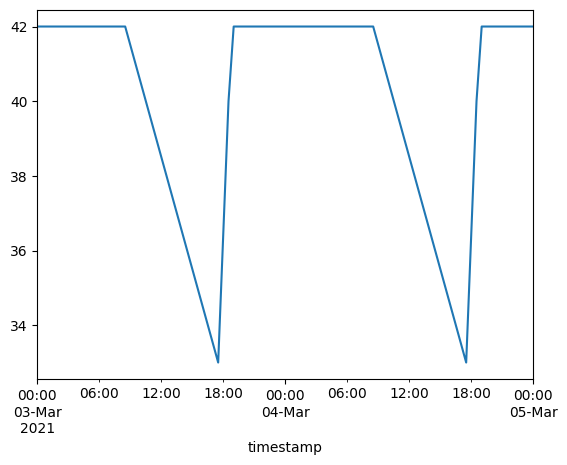

In [9]:
outputd["ev_battery_level_kWh"][datetime(year=2021,month=3,day=3):datetime(year=2021,month=3,day=5)].plot()